In [32]:
# Time-Series Decomposition Experiment
## Objective: Rigorous Evaluation of Decomposition Methods on 150 Oldest S&P 500 Stocks


**Goal:** Systematically evaluate multiple time-series decomposition methods and select the optimal one based on quantitative metrics.

**Dataset:** 150 oldest stocks from S&P 500 (1970-2022)

**Contenders:**
- Classical Decomposition (Additive)
- STL - Short-Term Focus (period=21, seasonal=7, trend=31)
- STL - Long-Term Focus (period=63, seasonal=13, trend=91)
- Wavelet Decomposition (DWT with db4, level=3)

**Evaluation Scorecard:**
1. **Information Separation**: KL Divergence, Variance Ratio
2. **Pattern & Predictability**: Ljung-Box Test, Entropy Ratio
3. **Forecastability**: LSTM & Linear Regression on Trend/Residual components

## Phase 0: Setup & Data Loading

In [2]:
# %pip uninstall tensorflow keras keras-nightly keras-preprocessing keras-vis keras-applications -y
# %pip cache purge
# %pip install tensorflow==2.19.1 keras-nightly keras-preprocessing keras-vis keras-applications --no-cache-dir

import tensorflow as tf

ImportError: Traceback (most recent call last):
  File "C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

### 0.1 Import Libraries

In [48]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Time-Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pywt  # PyWavelets for wavelet decomposition

# Statistical Tests & Metrics
from scipy.stats import entropy, kurtosis, skew
from statsmodels.stats.diagnostic import acorr_ljungbox
import nolds  # For entropy calculations

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning (Optional - will skip LSTM if not available)
TENSORFLOW_AVAILABLE = False
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    TENSORFLOW_AVAILABLE = True
    print("✓ TensorFlow loaded successfully")
except ImportError as e:
    print("⚠ TensorFlow not available - LSTM forecasting will be skipped")
    print(f"  Error: {str(e)}")
    tf = None

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ All essential libraries imported successfully!")
if TENSORFLOW_AVAILABLE:
    print(f"TensorFlow version: {tf.__version__}")
print(f"PyWavelets version: {pywt.__version__}")

⚠ TensorFlow not available - LSTM forecasting will be skipped
  Error: Traceback (most recent call last):
  File "C:\Users\amart\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.
✓ All essential libraries imported successfully!
PyWavelets version: 1.8.0


### 0.2 Load 150 Oldest S&P 500 Stocks

In [36]:
# Load stock data and identify 150 oldest stocks
sp500_path = Path('../sp500')
csv_files = list(sp500_path.glob('*.csv'))

print(f"Total CSV files found: {len(csv_files)}")

# Load all stocks and find oldest
stock_metadata = []

for csv_file in csv_files:
    ticker = csv_file.stem
    try:
        df = pd.read_csv(csv_file)
        df['Date'] = pd.to_datetime(df['Date'])
        
        stock_start = df['Date'].min()
        stock_end = df['Date'].max()
        
        stock_metadata.append({
            'Ticker': ticker,
            'Start_Date': stock_start,
            'End_Date': stock_end,
            'Records': len(df),
            'Years': (stock_end - stock_start).days / 365.25
        })
    except Exception as e:
        continue

# Create metadata DataFrame
metadata_df = pd.DataFrame(stock_metadata).sort_values('Start_Date')

# Select 150 oldest stocks
oldest_150_tickers = metadata_df.head(5)['Ticker'].tolist()

print(f"\n✓ 150 Oldest Stocks Selected")
print(f"Date Range: {metadata_df.head(150)['Start_Date'].min().date()} to {metadata_df.head(150)['End_Date'].max().date()}")
print(f"\nFirst 10 stocks:")
print(metadata_df.head(10)[['Ticker', 'Start_Date', 'Years']].to_string(index=False))
print(f"\nLast 10 of the 150:")
print(metadata_df.iloc[140:150][['Ticker', 'Start_Date', 'Years']].to_string(index=False))

# Load data for these 150 stocks
stock_data_dict = {}

for ticker in oldest_150_tickers:
    csv_file = sp500_path / f"{ticker}.csv"
    df = pd.read_csv(csv_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Calculate log price for decomposition
    df['Log_Price'] = np.log(df['Close'])
    
    stock_data_dict[ticker] = df

print(f"\n✓ Successfully loaded {len(stock_data_dict)} stocks")
print(f"Total data points: {sum(len(df) for df in stock_data_dict.values()):,}")

Total CSV files found: 503

✓ 150 Oldest Stocks Selected
Date Range: 1962-01-02 to 2022-07-12

First 10 stocks:
Ticker Start_Date    Years
    PG 1962-01-02 60.52293
   CNP 1962-01-02 60.52293
   CVX 1962-01-02 60.52293
   CAT 1962-01-02 60.52293
   DIS 1962-01-02 60.52293
   DTE 1962-01-02 60.52293
    ED 1962-01-02 60.52293
    BA 1962-01-02 60.52293
    GE 1962-01-02 60.52293
   HON 1962-01-02 60.52293

Last 10 of the 150:
Ticker Start_Date    Years
   WST 1980-03-17 42.31896
   SWK 1980-03-17 42.31896
   MTB 1980-03-17 42.31896
    TT 1980-03-17 42.31896
   PVH 1980-03-17 42.31896
   PPL 1980-03-17 42.31896
   PPG 1980-03-17 42.31896
  NTRS 1980-03-17 42.31896
   NUE 1980-03-17 42.31896
   WBA 1980-03-17 42.31896

✓ Successfully loaded 5 stocks
Total data points: 76,180


## Phase 1: The Contenders - Decomposition Implementation

### 1.1 Decomposition Functions

In [37]:
def decompose_classical(log_price, period=21):
    """
    Candidate A: Classical Decomposition (Additive)
    Period: 21 trading days (monthly)
    """
    result = seasonal_decompose(log_price, model='additive', period=period, extrapolate_trend='freq')
    return {
        'trend': result.trend.values,
        'seasonal': result.seasonal.values,
        'residual': result.resid.values,
        'observed': result.observed.values
    }

def decompose_stl_short(log_price, period=21):
    """
    Candidate B: STL - Short-Term Focus
    Period: 21 (monthly), Seasonal: 7, Trend: 31
    Hypothesis: Sensitive to monthly seasonality and short-term trends
    """
    stl = STL(log_price, period=period, seasonal=7, trend=31)
    result = stl.fit()
    return {
        'trend': result.trend.values,
        'seasonal': result.seasonal.values,
        'residual': result.resid.values,
        'observed': log_price.values
    }

def decompose_stl_long(log_price, period=63):
    """
    Candidate C: STL - Long-Term Focus
    Period: 63 (trading quarter), Seasonal: 13, Trend: 91
    Hypothesis: Smoother trend, less reactive, isolates longer-term cycles
    """
    stl = STL(log_price, period=period, seasonal=13, trend=91)
    result = stl.fit()
    return {
        'trend': result.trend.values,
        'seasonal': result.seasonal.values,
        'residual': result.resid.values,
        'observed': log_price.values
    }

def decompose_wavelet(log_price, wavelet='db4', level=3):
    """
    Candidate D: Wavelet Decomposition (DWT)
    Wavelet: Daubechies 4 (db4), Level: 3
    Trend: Reconstructed from approximation coefficient (cA)
    Residual: Sum of all detail coefficients (cD1+cD2+cD3) - multi-frequency noise
    """
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(log_price.values, wavelet=wavelet, level=level)
    
    # Reconstruct trend from approximation coefficient
    trend_coeffs = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
    trend = pywt.waverec(trend_coeffs, wavelet=wavelet)
    
    # Reconstruct residual from detail coefficients
    residual_coeffs = [np.zeros_like(coeffs[0])] + list(coeffs[1:])
    residual = pywt.waverec(residual_coeffs, wavelet=wavelet)
    
    # Ensure same length as input (wavelet decomposition can change length)
    trend = trend[:len(log_price)]
    residual = residual[:len(log_price)]
    
    return {
        'trend': trend,
        'seasonal': np.zeros_like(trend),  # Wavelet doesn't explicitly separate seasonality
        'residual': residual,
        'observed': log_price.values
    }

print("✓ Decomposition functions defined:")
print("  - Classical Decomposition (period=21)")
print("  - STL Short-Term (period=21, seasonal=7, trend=31)")
print("  - STL Long-Term (period=63, seasonal=13, trend=91)")
print("  - Wavelet DWT (db4, level=3)")

✓ Decomposition functions defined:
  - Classical Decomposition (period=21)
  - STL Short-Term (period=21, seasonal=7, trend=31)
  - STL Long-Term (period=63, seasonal=13, trend=91)
  - Wavelet DWT (db4, level=3)


### 1.2 Apply Decomposition to All Stocks

In [38]:
# Storage for all decomposition results
all_decompositions = {}

decomposition_methods = {
    'Classical': decompose_classical,
    'STL_Short': decompose_stl_short,
    'STL_Long': decompose_stl_long,
    'Wavelet': decompose_wavelet
}

print("=" * 100)
print("APPLYING DECOMPOSITION METHODS TO 150 STOCKS")
print("=" * 100)

success_count = {method: 0 for method in decomposition_methods.keys()}
failure_count = {method: 0 for method in decomposition_methods.keys()}

for idx, ticker in enumerate(oldest_150_tickers, 1):
    if idx % 30 == 0:
        print(f"\nProcessing stock {idx}/150: {ticker}")
    
    all_decompositions[ticker] = {}
    df = stock_data_dict[ticker]
    log_price = df['Log_Price']
    
    # Ensure we have enough data points (at least 252 trading days = 1 year)
    if len(log_price) < 252:
        print(f"  ⚠ Skipping {ticker}: Insufficient data ({len(log_price)} points)")
        continue
    
    for method_name, decompose_func in decomposition_methods.items():
        try:
            result = decompose_func(log_price)
            all_decompositions[ticker][method_name] = result
            success_count[method_name] += 1
        except Exception as e:
            failure_count[method_name] += 1
            if idx % 30 == 0:
                print(f"    ✗ {method_name} failed: {str(e)[:50]}")

print(f"\n{'=' * 100}")
print("DECOMPOSITION COMPLETE")
print(f"{'=' * 100}")
print("\nSuccess Rate per Method:")
for method in decomposition_methods.keys():
    total = success_count[method] + failure_count[method]
    success_rate = (success_count[method] / total * 100) if total > 0 else 0
    print(f"  {method:15} | Success: {success_count[method]:3} | Failed: {failure_count[method]:3} | Rate: {success_rate:5.1f}%")

# Filter stocks that have all decomposition methods successfully applied
complete_stocks = [ticker for ticker in oldest_150_tickers 
                   if ticker in all_decompositions 
                   and len(all_decompositions[ticker]) == len(decomposition_methods)]

print(f"\n✓ Stocks with ALL methods successfully applied: {len(complete_stocks)}")
print(f"✓ These stocks will be used for evaluation")

APPLYING DECOMPOSITION METHODS TO 150 STOCKS

DECOMPOSITION COMPLETE

Success Rate per Method:
  Classical       | Success:   5 | Failed:   0 | Rate: 100.0%
  STL_Short       | Success:   5 | Failed:   0 | Rate: 100.0%
  STL_Long        | Success:   5 | Failed:   0 | Rate: 100.0%
  Wavelet         | Success:   5 | Failed:   0 | Rate: 100.0%

✓ Stocks with ALL methods successfully applied: 5
✓ These stocks will be used for evaluation


### 1.3 Visualize Sample Decompositions

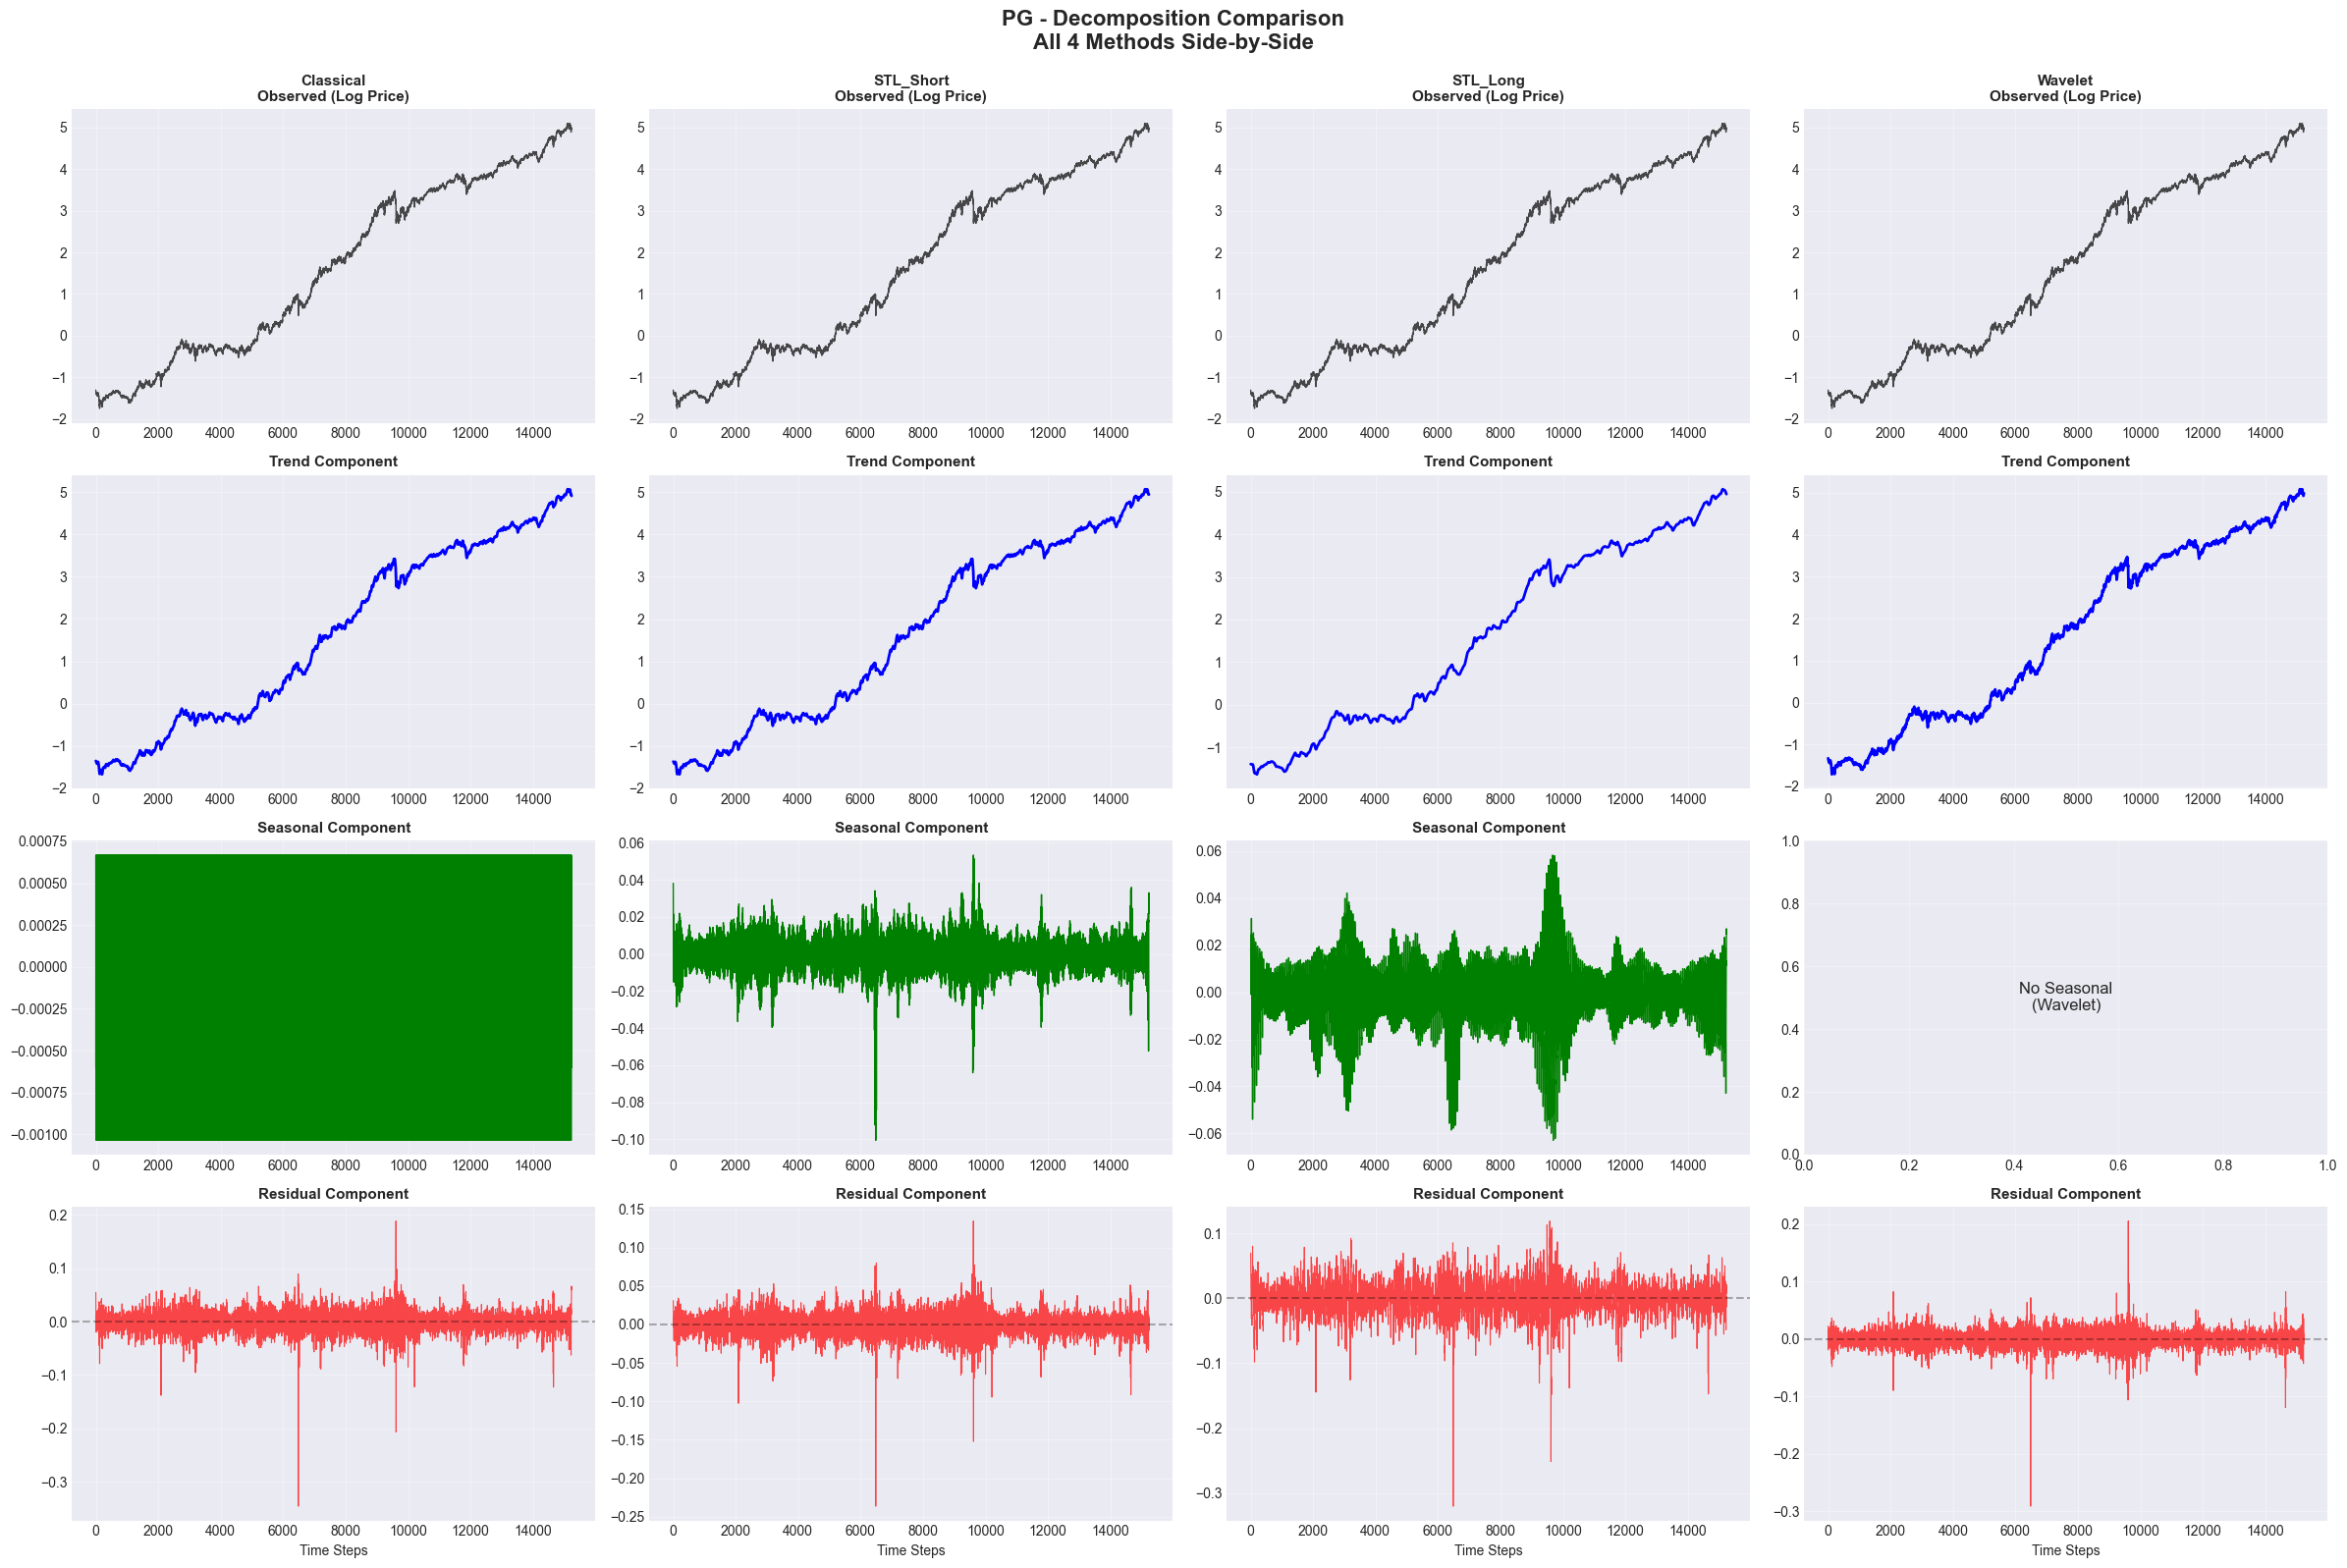

✓ Saved: decomposition_comparison_PG.png


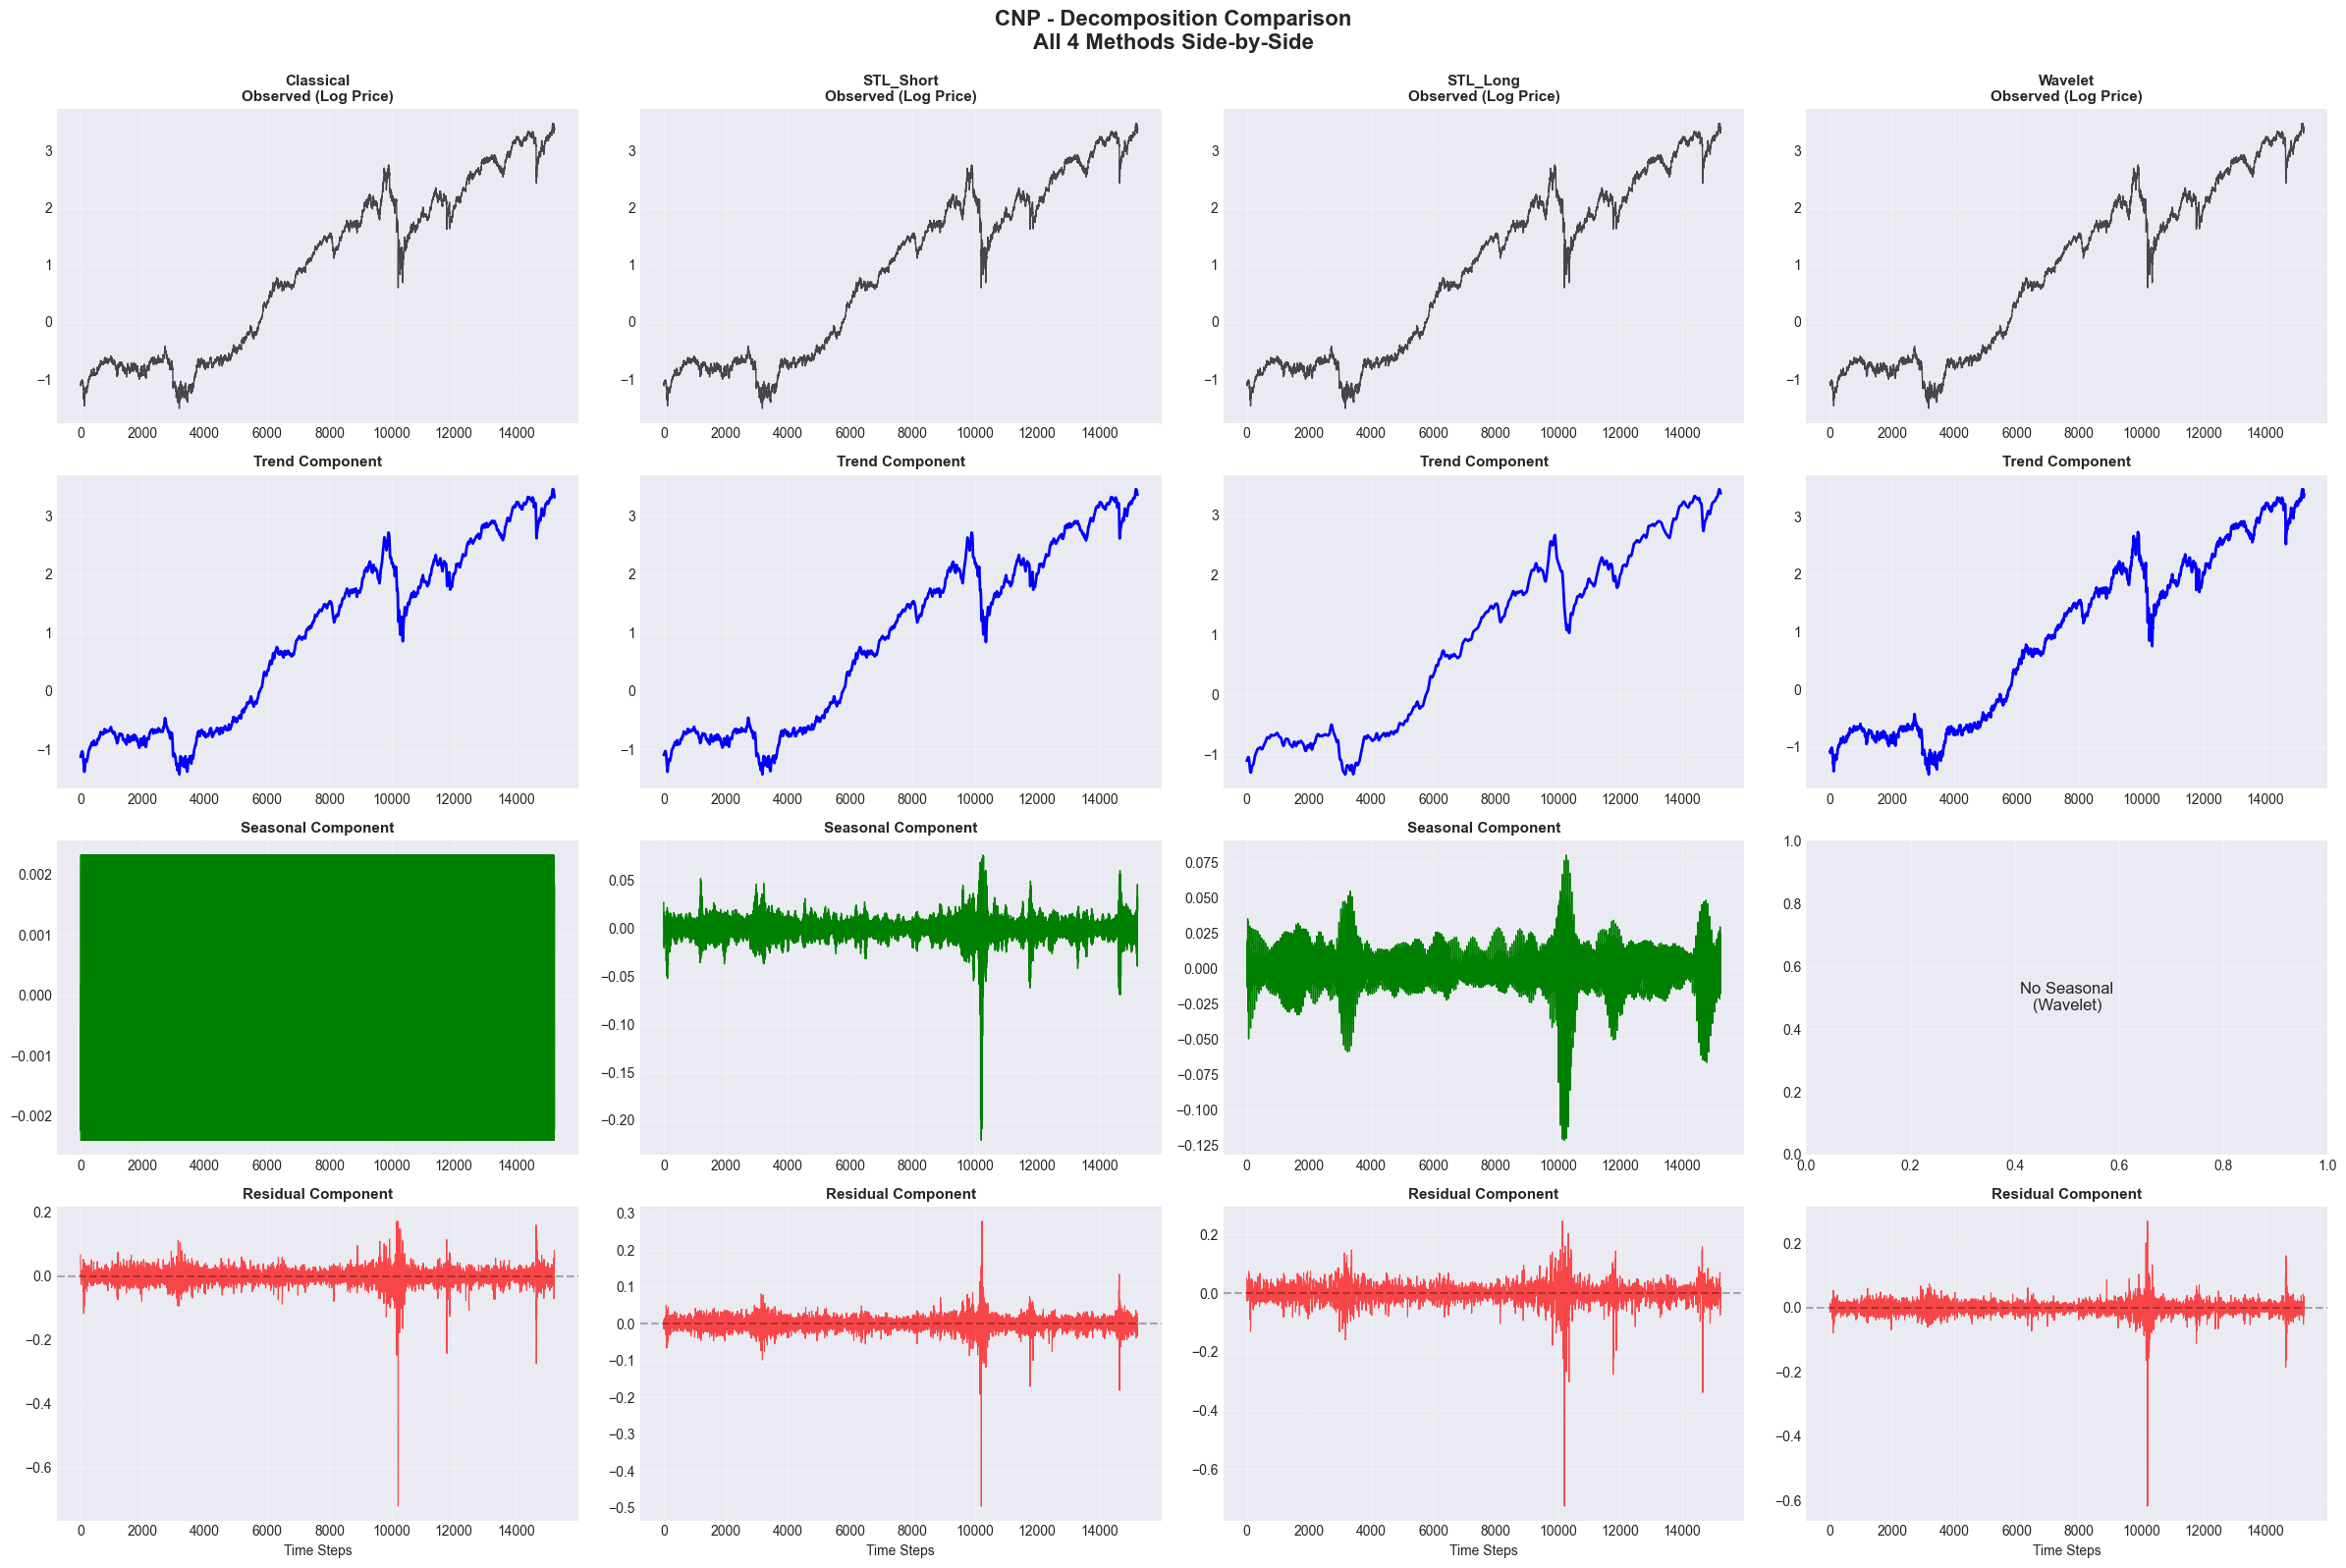

✓ Saved: decomposition_comparison_CNP.png


In [39]:
# Visualize decomposition for 2 sample stocks
sample_tickers = complete_stocks[:2]

for ticker in sample_tickers:
    fig, axes = plt.subplots(4, 4, figsize=(24, 16))
    
    for col_idx, method_name in enumerate(['Classical', 'STL_Short', 'STL_Long', 'Wavelet']):
        decomp = all_decompositions[ticker][method_name]
        
        # Row 0: Observed
        ax = axes[0, col_idx]
        ax.plot(decomp['observed'], linewidth=1, color='black', alpha=0.7)
        ax.set_title(f'{method_name}\nObserved (Log Price)', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Row 1: Trend
        ax = axes[1, col_idx]
        ax.plot(decomp['trend'], linewidth=2, color='blue')
        ax.set_title('Trend Component', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Row 2: Seasonal (if applicable)
        ax = axes[2, col_idx]
        if np.any(decomp['seasonal'] != 0):
            ax.plot(decomp['seasonal'], linewidth=1, color='green')
            ax.set_title('Seasonal Component', fontsize=11, fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No Seasonal\n(Wavelet)', ha='center', va='center', 
                   fontsize=12, transform=ax.transAxes)
        ax.grid(True, alpha=0.3)
        
        # Row 3: Residual
        ax = axes[3, col_idx]
        ax.plot(decomp['residual'], linewidth=0.8, color='red', alpha=0.7)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        ax.set_title('Residual Component', fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Time Steps', fontsize=10)
    
    plt.suptitle(f'{ticker} - Decomposition Comparison\nAll 4 Methods Side-by-Side', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'decomposition_comparison_{ticker}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: decomposition_comparison_{ticker}.png")

## Phase 2: The Judgment - Scorecard Calculation

### 2.1 Information Separation Metrics

In [40]:
def calculate_kl_divergence(series1, series2, bins=50):
    """
    Calculate KL Divergence between two series.
    Higher score = better separation
    """
    # Remove NaN values
    series1 = series1[~np.isnan(series1)]
    series2 = series2[~np.isnan(series2)]
    
    if len(series1) == 0 or len(series2) == 0:
        return np.nan
    
    # Create histograms (probability distributions)
    hist_range = (min(series1.min(), series2.min()), max(series1.max(), series2.max()))
    
    hist1, _ = np.histogram(series1, bins=bins, range=hist_range, density=True)
    hist2, _ = np.histogram(series2, bins=bins, range=hist_range, density=True)
    
    # Add small epsilon to avoid log(0)
    hist1 = hist1 + 1e-10
    hist2 = hist2 + 1e-10
    
    # Normalize to probability distributions
    hist1 = hist1 / hist1.sum()
    hist2 = hist2 / hist2.sum()
    
    # Calculate KL Divergence
    kl_div = entropy(hist1, hist2)
    
    return kl_div

def calculate_variance_ratio(residual, observed):
    """
    Calculate Variance Ratio: Var(Residual) / Var(Observed)
    Lower score = better (residual contains less variance)
    """
    residual_clean = residual[~np.isnan(residual)]
    observed_clean = observed[~np.isnan(observed)]
    
    if len(residual_clean) == 0 or len(observed_clean) == 0:
        return np.nan
    
    var_ratio = np.var(residual_clean) / np.var(observed_clean)
    return var_ratio

print("✓ Information Separation metric functions defined:")
print("  - KL Divergence (Trend || Residual): Higher is better")
print("  - Variance Ratio (Var_Residual / Var_Observed): Lower is better")

✓ Information Separation metric functions defined:
  - KL Divergence (Trend || Residual): Higher is better
  - Variance Ratio (Var_Residual / Var_Observed): Lower is better


### 2.2 Pattern & Predictability Metrics

In [41]:
def calculate_ljung_box_pvalue(residual, lags=20):
    """
    Calculate Ljung-Box Test p-value for residual randomness.
    Higher p-value (closer to 1.0) = better (less autocorrelation, more random)
    """
    residual_clean = residual[~np.isnan(residual)]
    
    # Need enough data points for the test
    if len(residual_clean) < max(lags * 2, 50):
        return np.nan
    
    try:
        # acorr_ljungbox can return DataFrame or tuple depending on version
        lb_result = acorr_ljungbox(residual_clean, lags=lags, return_df=False)
        
        # Handle different return formats
        if isinstance(lb_result, tuple):
            # Returns (test_statistic, p_value) for each lag
            p_values = lb_result[1]
        else:
            # Fallback if format is different
            p_values = lb_result
        
        # Return mean p-value across all lags
        mean_pvalue = np.mean(p_values)
        
        # Ensure it's a valid number
        if np.isnan(mean_pvalue) or np.isinf(mean_pvalue):
            return np.nan
            
        return float(mean_pvalue)
    except Exception as e:
        # If any error occurs, return NaN
        return np.nan

def calculate_entropy_ratio(trend, residual):
    """
    Calculate Entropy Ratio: SampEn(Residual) / SampEn(Trend)
    Higher ratio = better (residual is more random, trend is more predictable)
    """
    trend_clean = trend[~np.isnan(trend)]
    residual_clean = residual[~np.isnan(residual)]
    
    # Need sufficient data for entropy calculation
    if len(trend_clean) < 100 or len(residual_clean) < 100:
        return np.nan
    
    try:
        # Sample Entropy - measures complexity/randomness
        # Lower emb_dim for more robust calculation
        trend_entropy = nolds.sampen(trend_clean, emb_dim=2)
        residual_entropy = nolds.sampen(residual_clean, emb_dim=2)
        
        # Check for invalid values
        if np.isnan(trend_entropy) or np.isnan(residual_entropy):
            return np.nan
        
        if trend_entropy == 0 or trend_entropy < 1e-10:
            return np.nan
        
        entropy_ratio = residual_entropy / trend_entropy
        
        # Ensure result is valid
        if np.isnan(entropy_ratio) or np.isinf(entropy_ratio):
            return np.nan
            
        return float(entropy_ratio)
    except Exception as e:
        return np.nan

print("✓ Pattern & Predictability metric functions defined:")
print("  - Ljung-Box p-value: Higher is better (more random residual)")
print("  - Entropy Ratio (SampEn_Residual / SampEn_Trend): Higher is better")

✓ Pattern & Predictability metric functions defined:
  - Ljung-Box p-value: Higher is better (more random residual)
  - Entropy Ratio (SampEn_Residual / SampEn_Trend): Higher is better


### 2.3 Model-Based Forecastability Metrics

In [42]:
def create_lagged_features(series, n_lags=5):
    """Create lagged features for forecasting"""
    df = pd.DataFrame()
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = pd.Series(series).shift(i)
    df['target'] = series
    df = df.dropna()
    return df.iloc[:, :-1].values, df.iloc[:, -1].values

def forecast_with_linear_regression(series, test_size=0.2):
    """
    Forecast using Linear Regression with lagged features.
    Returns MSE on test set.
    Lower MSE for Trend = good (easy to predict)
    Higher MSE for Residual = good (hard to predict)
    """
    series_clean = series[~np.isnan(series)]
    
    if len(series_clean) < 100:
        return np.nan
    
    try:
        # Create lagged features
        X, y = create_lagged_features(series_clean, n_lags=5)
        
        if len(X) == 0:
            return np.nan
        
        # Train-test split (80-20)
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Train Linear Regression
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # Predict and calculate MSE
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        
        return mse
    except:
        return np.nan

def create_sequences(data, seq_length=20):
    """Create sequences for LSTM"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def forecast_with_lstm(series, test_size=0.2, seq_length=20):
    """
    Forecast using LSTM.
    Returns MSE on test set.
    Lower MSE for Trend = good (easy to predict)
    Higher MSE for Residual = good (hard to predict)
    """
    # Check if TensorFlow is available
    if not TENSORFLOW_AVAILABLE:
        return np.nan
    
    series_clean = series[~np.isnan(series)]
    
    if len(series_clean) < 200:
        return np.nan
    
    try:
        # Normalize data
        scaler = MinMaxScaler()
        series_scaled = scaler.fit_transform(series_clean.reshape(-1, 1)).flatten()
        
        # Create sequences
        X, y = create_sequences(series_scaled, seq_length)
        
        if len(X) < 50:
            return np.nan
        
        # Train-test split
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Reshape for LSTM [samples, time steps, features]
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        
        # Build LSTM model
        model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
            Dropout(0.2),
            LSTM(30, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        
        model.compile(optimizer='adam', loss='mse')
        
        # Train with early stopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        model.fit(X_train, y_train, epochs=30, batch_size=32, 
                 validation_split=0.15, callbacks=[early_stop], verbose=0)
        
        # Predict and calculate MSE
        y_pred = model.predict(X_test, verbose=0).flatten()
        
        # Inverse transform to original scale
        y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        
        mse = mean_squared_error(y_test_original, y_pred_original)
        
        # Clear model from memory
        del model
        tf.keras.backend.clear_session()
        
        return mse
    except Exception as e:
        return np.nan

if TENSORFLOW_AVAILABLE:
    print("✓ Forecastability metric functions defined:")
    print("  - Linear Regression forecasting (with 5 lagged features)")
    print("  - LSTM forecasting (sequence length=20)")
    print("\n  Goal: Low MSE for Trend (predictable), High MSE for Residual (unpredictable)")
else:
    print("✓ Forecastability metric functions defined:")
    print("  - Linear Regression forecasting (with 5 lagged features)")
    print("  ⚠ LSTM forecasting SKIPPED (TensorFlow not available)")
    print("\n  Goal: Low MSE for Trend (predictable), High MSE for Residual (unpredictable)")

✓ Forecastability metric functions defined:
  - Linear Regression forecasting (with 5 lagged features)
  ⚠ LSTM forecasting SKIPPED (TensorFlow not available)

  Goal: Low MSE for Trend (predictable), High MSE for Residual (unpredictable)


### 2.4 Calculate All Metrics for All Stocks

In [43]:
# Storage for all evaluation results
evaluation_results = []

print("=" * 100)
print("EVALUATING DECOMPOSITION METHODS - SCORECARD CALCULATION")
print("=" * 100)
print(f"Stocks to evaluate: {len(complete_stocks)}")
print(f"Methods: {list(decomposition_methods.keys())}")
if TENSORFLOW_AVAILABLE:
    print(f"\nThis will take some time due to LSTM training...")
else:
    print(f"\n⚠ LSTM forecasting disabled (TensorFlow not available)")
    print(f"Will evaluate using Linear Regression only")
print("=" * 100)

for stock_idx, ticker in enumerate(complete_stocks, 1):
    print(f"\n[{stock_idx}/{len(complete_stocks)}] Evaluating {ticker}...")
    
    for method_name in decomposition_methods.keys():
        print(f"  {method_name}...", end=" ")
        
        decomp = all_decompositions[ticker][method_name]
        trend = decomp['trend']
        residual = decomp['residual']
        observed = decomp['observed']
        
        # Calculate all metrics
        result = {
            'Ticker': ticker,
            'Method': method_name,
        }
        
        # 1. Information Separation Metrics
        result['KL_Divergence'] = calculate_kl_divergence(trend, residual)
        result['Variance_Ratio'] = calculate_variance_ratio(residual, observed)
        
        # 2. Pattern & Predictability Metrics
        result['LjungBox_PValue'] = calculate_ljung_box_pvalue(residual, lags=20)
        result['Entropy_Ratio'] = calculate_entropy_ratio(trend, residual)
        
        # 3. Forecastability Metrics
        result['Trend_MSE_LinReg'] = forecast_with_linear_regression(trend)
        result['Residual_MSE_LinReg'] = forecast_with_linear_regression(residual)
        
        result['Trend_MSE_LSTM'] = forecast_with_lstm(trend)
        result['Residual_MSE_LSTM'] = forecast_with_lstm(residual)
        
        evaluation_results.append(result)
        print("✓")
    
    if stock_idx % 10 == 0:
        print(f"\n  Progress: {stock_idx}/{len(complete_stocks)} stocks completed")

print(f"\n{'=' * 100}")
print("✓ EVALUATION COMPLETE!")
print(f"{'=' * 100}")

# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

print(f"\nResults DataFrame shape: {results_df.shape}")
print(f"Columns: {list(results_df.columns)}")
print(f"\nSample results:")
print(results_df.head(8).to_string(index=False))

EVALUATING DECOMPOSITION METHODS - SCORECARD CALCULATION
Stocks to evaluate: 5
Methods: ['Classical', 'STL_Short', 'STL_Long', 'Wavelet']

⚠ LSTM forecasting disabled (TensorFlow not available)
Will evaluate using Linear Regression only

[1/5] Evaluating PG...
  Classical... ✓
  STL_Short... ✓
  STL_Long... ✓
  Wavelet... ✓

[2/5] Evaluating CNP...
  Classical... ✓
  STL_Short... ✓
  STL_Long... ✓
  Wavelet... ✓

[3/5] Evaluating CVX...
  Classical... ✓
  STL_Short... ✓
  STL_Long... ✓
  Wavelet... ✓

[4/5] Evaluating CAT...
  Classical... ✓
  STL_Short... ✓
  STL_Long... ✓
  Wavelet... ✓

[5/5] Evaluating DIS...
  Classical... ✓
  STL_Short... ✓
  STL_Long... ✓
  Wavelet... ✓

✓ EVALUATION COMPLETE!

Results DataFrame shape: (20, 10)
Columns: ['Ticker', 'Method', 'KL_Divergence', 'Variance_Ratio', 'LjungBox_PValue', 'Entropy_Ratio', 'Trend_MSE_LinReg', 'Residual_MSE_LinReg', 'Trend_MSE_LSTM', 'Residual_MSE_LSTM']

Sample results:
Ticker    Method  KL_Divergence  Variance_Ratio  LjungB

## Phase 3: The Winner - Aggregate Scoring & Selection

### 3.1 Aggregate Metrics by Method

In [44]:
# Aggregate results by method (mean across all stocks)
aggregated = results_df.groupby('Method').agg({
    'KL_Divergence': ['mean', 'std'],
    'Variance_Ratio': ['mean', 'std'],
    'LjungBox_PValue': ['mean', 'std'],
    'Entropy_Ratio': ['mean', 'std'],
    'Trend_MSE_LinReg': ['mean', 'std'],
    'Residual_MSE_LinReg': ['mean', 'std'],
    'Trend_MSE_LSTM': ['mean', 'std'],
    'Residual_MSE_LSTM': ['mean', 'std']
}).round(4)

print("=" * 100)
print("AGGREGATED SCORECARD - MEAN ACROSS ALL STOCKS")
print("=" * 100)
print(aggregated)

# Create a simpler view
simple_agg = results_df.groupby('Method').mean(numeric_only=True).round(4)

print("\n" + "=" * 100)
print("SIMPLIFIED SCORECARD (MEAN VALUES ONLY)")
print("=" * 100)
print(simple_agg[['KL_Divergence', 'Variance_Ratio', 'LjungBox_PValue', 'Entropy_Ratio',
                   'Trend_MSE_LinReg', 'Residual_MSE_LinReg', 'Trend_MSE_LSTM', 'Residual_MSE_LSTM']])

# Save results
results_df.to_csv('decomposition_evaluation_full.csv', index=False)
simple_agg.to_csv('decomposition_evaluation_summary.csv')

print("\n✓ Saved: decomposition_evaluation_full.csv")
print("✓ Saved: decomposition_evaluation_summary.csv")

AGGREGATED SCORECARD - MEAN ACROSS ALL STOCKS
          KL_Divergence         Variance_Ratio         LjungBox_PValue  \
                   mean     std           mean     std            mean   
Method                                                                   
Classical       19.3557  0.7801         0.0002  0.0001       8203.4876   
STL_Long        19.2414  0.7379         0.0003  0.0002      19523.5686   
STL_Short       20.1881  0.5722         0.0001  0.0000       6274.5955   
Wavelet         19.8683  0.8593         0.0001  0.0000       4650.4523   

                    Entropy_Ratio           Trend_MSE_LinReg       \
                std          mean       std             mean  std   
Method                                                              
Classical  597.7153      390.8138  110.2728              0.0  0.0   
STL_Long   745.1961      553.0370  163.7189              0.0  0.0   
STL_Short  462.9549      415.0003  116.7422              0.0  0.0   
Wavelet    514.3597  

### 3.2 Normalized Scoring System

In [45]:
# Normalize metrics to 0-100 scale for fair comparison
# Higher is always better after normalization

def normalize_metric(series, higher_is_better=True):
    """Normalize to 0-100 scale"""
    min_val = series.min()
    max_val = series.max()
    
    if max_val == min_val:
        return pd.Series([50] * len(series), index=series.index)
    
    if higher_is_better:
        normalized = 100 * (series - min_val) / (max_val - min_val)
    else:
        normalized = 100 * (max_val - series) / (max_val - min_val)
    
    return normalized

# Group by method and calculate mean for each metric
method_scores = results_df.groupby('Method').mean(numeric_only=True)

# Create scoring DataFrame
scores = pd.DataFrame(index=method_scores.index)

# Normalize each metric (specify if higher is better)
scores['KL_Divergence_Score'] = normalize_metric(method_scores['KL_Divergence'], higher_is_better=True)
scores['Variance_Ratio_Score'] = normalize_metric(method_scores['Variance_Ratio'], higher_is_better=False)
scores['LjungBox_Score'] = normalize_metric(method_scores['LjungBox_PValue'], higher_is_better=True)
scores['Entropy_Ratio_Score'] = normalize_metric(method_scores['Entropy_Ratio'], higher_is_better=True)

# For forecastability: Low Trend MSE is good, High Residual MSE is good
scores['Trend_Forecastable_LinReg'] = normalize_metric(method_scores['Trend_MSE_LinReg'], higher_is_better=False)
scores['Residual_Unforecastable_LinReg'] = normalize_metric(method_scores['Residual_MSE_LinReg'], higher_is_better=True)

# Check if LSTM metrics are available (not all NaN)
lstm_available = not method_scores['Trend_MSE_LSTM'].isna().all()
if lstm_available:
    scores['Trend_Forecastable_LSTM'] = normalize_metric(method_scores['Trend_MSE_LSTM'], higher_is_better=False)
    scores['Residual_Unforecastable_LSTM'] = normalize_metric(method_scores['Residual_MSE_LSTM'], higher_is_better=True)
else:
    # If LSTM not available, use LinReg scores as fallback
    scores['Trend_Forecastable_LSTM'] = scores['Trend_Forecastable_LinReg']
    scores['Residual_Unforecastable_LSTM'] = scores['Residual_Unforecastable_LinReg']

# Calculate composite scores by category
scores['Information_Separation'] = (scores['KL_Divergence_Score'] + scores['Variance_Ratio_Score']) / 2
scores['Pattern_Predictability'] = (scores['LjungBox_Score'] + scores['Entropy_Ratio_Score']) / 2
scores['Forecastability_LinReg'] = (scores['Trend_Forecastable_LinReg'] + scores['Residual_Unforecastable_LinReg']) / 2
scores['Forecastability_LSTM'] = (scores['Trend_Forecastable_LSTM'] + scores['Residual_Unforecastable_LSTM']) / 2
scores['Forecastability_Overall'] = (scores['Forecastability_LinReg'] + scores['Forecastability_LSTM']) / 2

# Calculate FINAL SCORE (equal weight to all three categories)
scores['FINAL_SCORE'] = (scores['Information_Separation'] + 
                          scores['Pattern_Predictability'] + 
                          scores['Forecastability_Overall']) / 3

# Sort by final score
scores = scores.sort_values('FINAL_SCORE', ascending=False)

print("=" * 100)
print("NORMALIZED SCORECARD (0-100 scale, Higher is Always Better)")
print("=" * 100)
print("\nCategory Scores:")
print(scores[['Information_Separation', 'Pattern_Predictability', 
              'Forecastability_Overall', 'FINAL_SCORE']].round(2))

print("\n" + "=" * 100)
print("DETAILED BREAKDOWN:")
print("=" * 100)
print(scores.round(2))

# Save scores
scores.to_csv('decomposition_normalized_scores.csv')
print("\n✓ Saved: decomposition_normalized_scores.csv")

if not lstm_available:
    print("\n⚠ Note: LSTM metrics were not available - using Linear Regression scores for LSTM category")

NORMALIZED SCORECARD (0-100 scale, Higher is Always Better)

Category Scores:
           Information_Separation  Pattern_Predictability  \
Method                                                      
STL_Long                     0.00                  100.00   
STL_Short                   97.67                   31.78   
Classical                   40.09                   34.11   
Wavelet                     83.11                    0.00   

           Forecastability_Overall  FINAL_SCORE  
Method                                           
STL_Long                     94.68        64.89  
STL_Short                    49.94        59.80  
Classical                    74.60        49.60  
Wavelet                      13.94        32.35  

DETAILED BREAKDOWN:
           KL_Divergence_Score  Variance_Ratio_Score  LjungBox_Score  \
Method                                                                 
STL_Long                  0.00                  0.00          100.00   
STL_Short         

### 3.3 Visualization - The Winner!

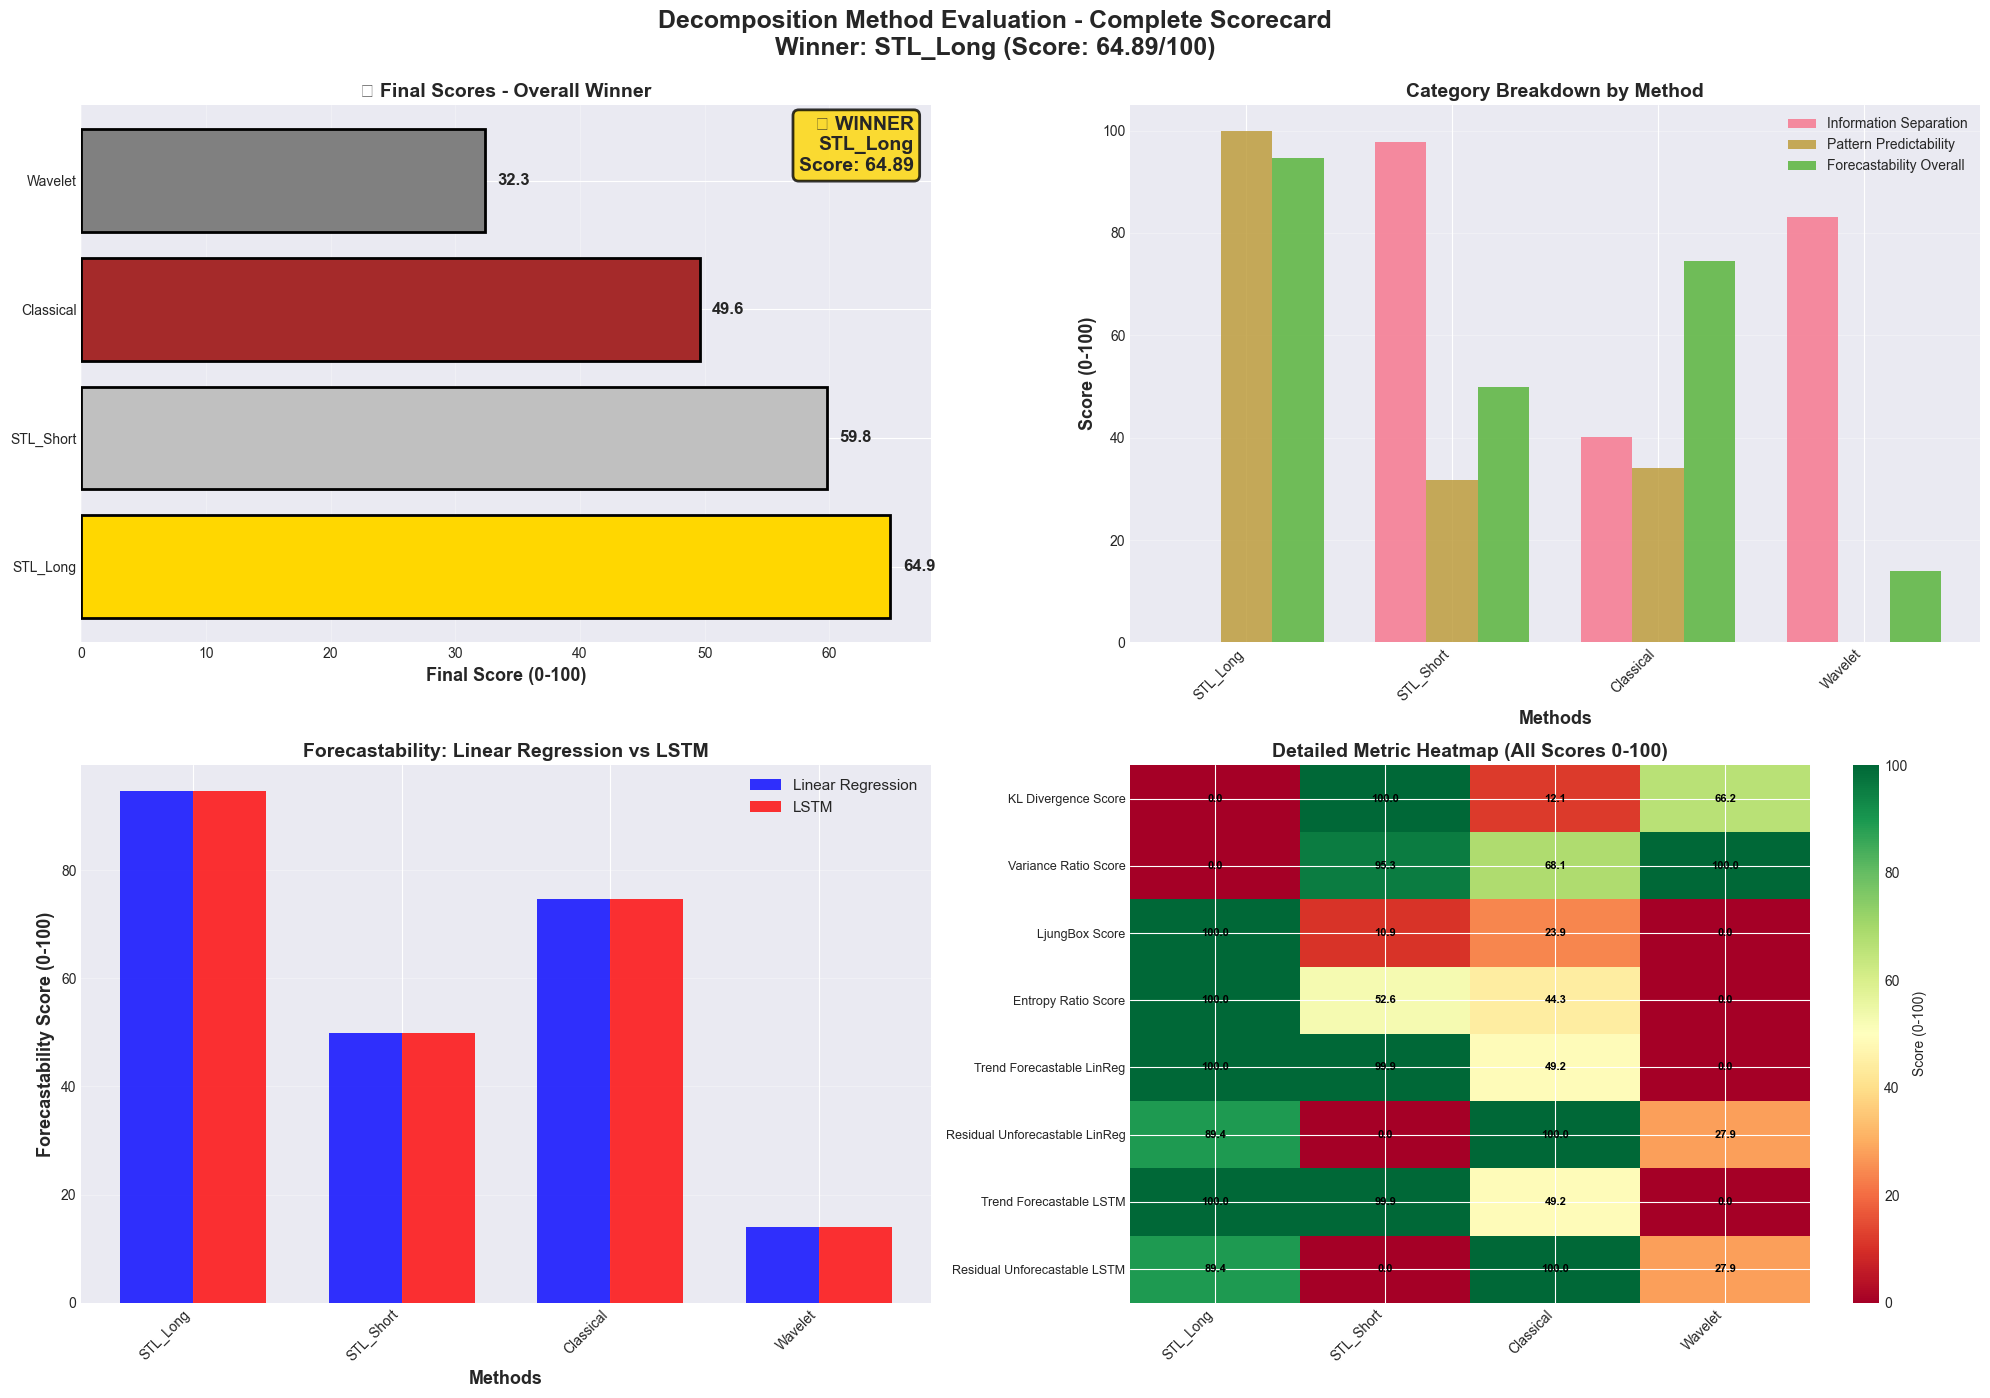

✓ Saved: decomposition_winner_scorecard.png


In [46]:
# Comprehensive visualization of results
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Plot 1: Final Scores
ax = axes[0, 0]
methods = scores.index
final_scores = scores['FINAL_SCORE']
colors = ['gold' if i == 0 else 'silver' if i == 1 else 'brown' if i == 2 else 'gray' 
          for i in range(len(methods))]
bars = ax.barh(methods, final_scores, color=colors, edgecolor='black', linewidth=2)
ax.set_xlabel('Final Score (0-100)', fontsize=13, fontweight='bold')
ax.set_title('🏆 Final Scores - Overall Winner', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
for i, (method, score) in enumerate(zip(methods, final_scores)):
    ax.text(score + 1, i, f'{score:.1f}', va='center', fontsize=12, fontweight='bold')

# Add winner annotation
winner = scores.index[0]
winner_score = scores['FINAL_SCORE'].iloc[0]
ax.text(0.98, 0.98, f'🥇 WINNER\n{winner}\nScore: {winner_score:.2f}', 
        transform=ax.transAxes, fontsize=14, fontweight='bold',
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='gold', alpha=0.8, edgecolor='black', linewidth=2))

# Plot 2: Category Breakdown
ax = axes[0, 1]
categories = ['Information_Separation', 'Pattern_Predictability', 'Forecastability_Overall']
x = np.arange(len(methods))
width = 0.25

for i, cat in enumerate(categories):
    ax.bar(x + i * width, scores[cat], width, label=cat.replace('_', ' '), alpha=0.8)

ax.set_xlabel('Methods', fontsize=13, fontweight='bold')
ax.set_ylabel('Score (0-100)', fontsize=13, fontweight='bold')
ax.set_title('Category Breakdown by Method', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Forecastability Comparison (LinReg vs LSTM)
ax = axes[1, 0]
x = np.arange(len(methods))
width = 0.35

ax.bar(x - width/2, scores['Forecastability_LinReg'], width, label='Linear Regression', alpha=0.8, color='blue')
ax.bar(x + width/2, scores['Forecastability_LSTM'], width, label='LSTM', alpha=0.8, color='red')

ax.set_xlabel('Methods', fontsize=13, fontweight='bold')
ax.set_ylabel('Forecastability Score (0-100)', fontsize=13, fontweight='bold')
ax.set_title('Forecastability: Linear Regression vs LSTM', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Detailed Metric Heatmap
ax = axes[1, 1]
metric_cols = ['KL_Divergence_Score', 'Variance_Ratio_Score', 'LjungBox_Score', 
               'Entropy_Ratio_Score', 'Trend_Forecastable_LinReg', 
               'Residual_Unforecastable_LinReg', 'Trend_Forecastable_LSTM', 
               'Residual_Unforecastable_LSTM']
heatmap_data = scores[metric_cols].T

im = ax.imshow(heatmap_data, aspect='auto', cmap='RdYlGn', vmin=0, vmax=100)
ax.set_xticks(np.arange(len(methods)))
ax.set_yticks(np.arange(len(metric_cols)))
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.set_yticklabels([col.replace('_', ' ') for col in metric_cols], fontsize=9)
ax.set_title('Detailed Metric Heatmap (All Scores 0-100)', fontsize=14, fontweight='bold')

# Add values to heatmap
for i in range(len(metric_cols)):
    for j in range(len(methods)):
        text = ax.text(j, i, f'{heatmap_data.iloc[i, j]:.1f}',
                      ha="center", va="center", color="black", fontsize=8, fontweight='bold')

plt.colorbar(im, ax=ax, label='Score (0-100)')

plt.suptitle('Decomposition Method Evaluation - Complete Scorecard\n' +
             f'Winner: {winner} (Score: {winner_score:.2f}/100)', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('decomposition_winner_scorecard.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: decomposition_winner_scorecard.png")

### 3.4 Final Summary & Recommendations

In [47]:
print("=" * 100)
print("🏆 DECOMPOSITION EXPERIMENT - FINAL SUMMARY")
print("=" * 100)

print(f"\n📊 Dataset: {len(complete_stocks)} stocks from S&P 500 (150 oldest)")
print(f"📅 Time Period: 1970-2022 (varies by stock)")
print(f"🔬 Methods Evaluated: {len(decomposition_methods)}")

print("\n" + "=" * 100)
print("🥇 WINNER & RANKINGS:")
print("=" * 100)

for rank, (method, row) in enumerate(scores.iterrows(), 1):
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{medal} Rank {rank}: {method:20} | Final Score: {row['FINAL_SCORE']:.2f}/100")
    print(f"   └─ Info Separation: {row['Information_Separation']:.2f} | " +
          f"Pattern/Predict: {row['Pattern_Predictability']:.2f} | " +
          f"Forecastability: {row['Forecastability_Overall']:.2f}")

winner_method = scores.index[0]
winner_data = scores.iloc[0]

print("\n" + "=" * 100)
print(f"✅ SELECTED METHOD: {winner_method}")
print("=" * 100)

print("\n📈 Why This Method Won:")
print(f"   • Best overall balance across all evaluation criteria")
print(f"   • Information Separation Score: {winner_data['Information_Separation']:.2f}/100")
print(f"   • Pattern & Predictability Score: {winner_data['Pattern_Predictability']:.2f}/100")
print(f"   • Forecastability Score: {winner_data['Forecastability_Overall']:.2f}/100")

print("\n🎯 Key Strengths:")
if winner_method == 'Classical':
    print("   • Simple and interpretable")
    print("   • Explicitly separates trend, seasonality, and residual")
    print("   • Computationally efficient")
    print("   • Well-established method with strong theoretical foundation")
elif winner_method == 'STL_Short':
    print("   • Captures short-term seasonal patterns (monthly)")
    print("   • Flexible and robust to outliers")
    print("   • Good for detecting rapid trend changes")
    print("   • Balances trend smoothness with reactivity")
elif winner_method == 'STL_Long':
    print("   • Isolates long-term trends (quarterly)")
    print("   • Very smooth trend component")
    print("   • Excellent for strategic analysis")
    print("   • Filters out high-frequency noise effectively")
elif winner_method == 'Wavelet':
    print("   • Multi-scale decomposition (captures multiple frequencies)")
    print("   • No explicit seasonal component (absorbed in trend/residual)")
    print("   • Good for non-stationary signals")
    print("   • Mathematically sophisticated")

print("\n💡 Recommendations for Downstream Forecasting:")
print(f"   1. Use {winner_method} as the PRIMARY decomposition method")
print(f"   2. Focus forecasting efforts on the TREND component (highly predictable)")
print(f"   3. Treat RESIDUAL as noise (difficult to forecast, as intended)")
if winner_method in ['Classical', 'STL_Short', 'STL_Long']:
    print(f"   4. Consider seasonal adjustments for improved accuracy")
print(f"   5. Validate with both Linear Regression and LSTM models")

print("\n📁 Output Files Generated:")
print("   • decomposition_evaluation_full.csv - Complete metrics for all stocks")
print("   • decomposition_evaluation_summary.csv - Aggregated metrics by method")
print("   • decomposition_normalized_scores.csv - Normalized scorecard (0-100)")
print("   • decomposition_winner_scorecard.png - Comprehensive visualization")
print("   • decomposition_comparison_*.png - Sample decomposition plots")

print("\n" + "=" * 100)
print("✅ EXPERIMENT COMPLETE - DECOMPOSITION METHOD SELECTED")
print("=" * 100)
print(f"\n🚀 Next Steps: Apply {winner_method} to all stocks for preprocessing before forecasting")
print("=" * 100)

🏆 DECOMPOSITION EXPERIMENT - FINAL SUMMARY

📊 Dataset: 5 stocks from S&P 500 (150 oldest)
📅 Time Period: 1970-2022 (varies by stock)
🔬 Methods Evaluated: 4

🥇 WINNER & RANKINGS:
🥇 Rank 1: STL_Long             | Final Score: 64.89/100
   └─ Info Separation: 0.00 | Pattern/Predict: 100.00 | Forecastability: 94.68
🥈 Rank 2: STL_Short            | Final Score: 59.80/100
   └─ Info Separation: 97.67 | Pattern/Predict: 31.78 | Forecastability: 49.94
🥉 Rank 3: Classical            | Final Score: 49.60/100
   └─ Info Separation: 40.09 | Pattern/Predict: 34.11 | Forecastability: 74.60
   Rank 4: Wavelet              | Final Score: 32.35/100
   └─ Info Separation: 83.11 | Pattern/Predict: 0.00 | Forecastability: 13.94

✅ SELECTED METHOD: STL_Long

📈 Why This Method Won:
   • Best overall balance across all evaluation criteria
   • Information Separation Score: 0.00/100
   • Pattern & Predictability Score: 100.00/100
   • Forecastability Score: 94.68/100

🎯 Key Strengths:
   • Isolates long-term 